# Predictive Maintenance - Case Study


## Project Overview

This project focuses on building a predictive maintenance system for aircraft engines using Recurrent Neural Networks (RNNs). Aircraft engines are equipped with multiple sensors that continuously record operational parameters during each flight cycle. Analyzing this time-series sensor data enables early detection of potential engine failures.

The objective of this project is to leverage deep learning techniques to learn temporal patterns in multivariate sensor data and predict impending engine failures before they occur.


## Problem Statement

Given historical multivariate time-series sensor data collected from aircraft engines across multiple flight cycles, the objective is to predict whether an engine will experience a failure within a predefined future time window.

The problem is formulated as a binary classification task:
- 1 → Engine failure within the prediction window  
- 0 → No engine failure within the prediction window  

The model learns temporal dependencies in engine sensor readings to identify degradation patterns that precede failures.


## Business Impact

Predictive maintenance for aircraft engines plays a critical role in aviation safety and operational efficiency. A reliable failure prediction system can:
- Improve flight safety by detecting early signs of engine degradation
- Reduce unscheduled maintenance and flight delays
- Optimize maintenance planning and spare part logistics
- Extend engine life by preventing catastrophic failures


## Technical Framing

Aircraft engine sensor data is inherently sequential, where current engine health depends on historical operating conditions across multiple flight cycles. Traditional machine learning models struggle to capture these temporal dependencies.

Recurrent Neural Networks (RNNs) are well-suited for this task as they can model sequential patterns and learn long-term dependencies in time-series data, making them effective for predictive maintenance applications.


## Dataset Source

The dataset used in this project was obtained from Kaggle and contains simulated aircraft engine sensor data for predictive maintenance analysis. The dataset consists of separate training, test, and ground truth files and follows a structure commonly used in aircraft engine degradation and failure prediction studies.
  
The structure and format of the dataset are consistent with the CMAPSS-style aircraft engine simulation data commonly used in predictive maintenance research.


## Dataset Structure

The training and test datasets consist of multivariate time-series data collected from multiple aircraft engines. Each row represents a single flight cycle for a specific engine.


### Columns Description

Each record in the training and test datasets contains the following fields:

- **Engine ID**: Unique identifier for each aircraft engine  
- **Cycle Number**: Represents the flight cycle index for a given engine  
- **Operational Settings (Setting1, Setting2, Setting3)**: Describe different operating conditions under which the engine was running  
- **Sensor Measurements (S1 – S21)**: Continuous sensor readings capturing various aspects of engine performance and health


### Truth Dataset

The truth dataset contains the remaining number of operational cycles for each engine in the test dataset before failure occurs. This information is used to derive the target labels for model evaluation.


### Target Label Definition

The remaining useful life (RUL) information from the truth dataset is converted into a binary target variable. Engines are labeled as:
- 1 → Failure occurs within the predefined prediction window  
- 0 → Failure does not occur within the prediction window


| Column Type            | Description                          |
|------------------------|--------------------------------------|
| Engine ID              | Unique engine identifier             |
| Cycle Number           | Flight cycle index                   |
| Operational Settings   | Engine operating conditions (3)      |
| Sensor Measurements    | Engine health indicators (21 sensors)|


## Environment Setup

This section initializes the required libraries and loads the datasets needed for exploratory data analysis and model development.


In [1]:
# Core libraries
import os
import numpy as np
import pandas as pd

# Set random seed for reproducibility
np.random.seed(1234)

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, recall_score, precision_score

# Deep Learning
# from tensorflow import keras
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout,GRU
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint,CSVLogger


## Data Loading and Column Assignment

This section loads the training, test, and ground truth datasets and assigns meaningful column names to the raw data. The datasets are also sorted by engine ID and cycle number to preserve the temporal order required for time-series modeling.


In [2]:
# ----------------------------------
# Define dataset path
# ----------------------------------
path = "/content/drive/MyDrive/PredictiveMaintenanceCaseStudy-RNN/"

# ----------------------------------
# Load datasets
# ----------------------------------
df_train = pd.read_csv(path + "PM_train.txt", sep=" ", header=None)
df_test  = pd.read_csv(path + "PM_test.txt",  sep=" ", header=None)
df_truth = pd.read_csv(path + "PM_truth.txt", sep=" ", header=None)

# ----------------------------------
# Remove extra empty columns
# (Generated due to space-separated format)
# ----------------------------------
df_train.dropna(axis=1, how="all", inplace=True)
df_test.dropna(axis=1, how="all", inplace=True)


# ----------------------------------
# Assign column names
# ----------------------------------
col_names = (
    ["id", "cycle", "setting1", "setting2", "setting3"] +
    [f"s{i}" for i in range(1, 22)]
)

df_train.columns = col_names
df_test.columns  = col_names

# ----------------------------------
# Sort data to maintain temporal order
# ----------------------------------
df_train.sort_values(["id", "cycle"], inplace=True)
df_test.sort_values(["id", "cycle"], inplace=True)


In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20631 entries, 0 to 20630
Data columns (total 26 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        20631 non-null  int64  
 1   cycle     20631 non-null  int64  
 2   setting1  20631 non-null  float64
 3   setting2  20631 non-null  float64
 4   setting3  20631 non-null  float64
 5   s1        20631 non-null  float64
 6   s2        20631 non-null  float64
 7   s3        20631 non-null  float64
 8   s4        20631 non-null  float64
 9   s5        20631 non-null  float64
 10  s6        20631 non-null  float64
 11  s7        20631 non-null  float64
 12  s8        20631 non-null  float64
 13  s9        20631 non-null  float64
 14  s10       20631 non-null  float64
 15  s11       20631 non-null  float64
 16  s12       20631 non-null  float64
 17  s13       20631 non-null  float64
 18  s14       20631 non-null  float64
 19  s15       20631 non-null  float64
 20  s16       20631 non-null  fl

In [4]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13096 entries, 0 to 13095
Data columns (total 26 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        13096 non-null  int64  
 1   cycle     13096 non-null  int64  
 2   setting1  13096 non-null  float64
 3   setting2  13096 non-null  float64
 4   setting3  13096 non-null  float64
 5   s1        13096 non-null  float64
 6   s2        13096 non-null  float64
 7   s3        13096 non-null  float64
 8   s4        13096 non-null  float64
 9   s5        13096 non-null  float64
 10  s6        13096 non-null  float64
 11  s7        13096 non-null  float64
 12  s8        13096 non-null  float64
 13  s9        13096 non-null  float64
 14  s10       13096 non-null  float64
 15  s11       13096 non-null  float64
 16  s12       13096 non-null  float64
 17  s13       13096 non-null  float64
 18  s14       13096 non-null  float64
 19  s15       13096 non-null  float64
 20  s16       13096 non-null  fl

## Remaining Useful Life (RUL) Computation



### For training data


For the training, each engine operates until failure.  
The Remaining Useful Life (RUL) at each cycle is computed as the difference between the maximum cycle (failure point) and the current cycle.

The RUL values are then converted into a binary classification label indicating whether an engine will fail within a predefined prediction window.

In [5]:
# ----------------------------------
# Compute maximum cycle (failure point) per engine
# ----------------------------------
rul_df = (
    df_train
    .groupby("id")["cycle"]
    .max()
    .reset_index()
    .rename(columns={"cycle": "max_cycle"})
)

# ----------------------------------
# Merge failure point back into training data
# ----------------------------------
df_train = df_train.merge(rul_df, on="id", how="left")

# ----------------------------------
# Calculate Remaining Useful Life (RUL)
# ----------------------------------
df_train["RUL"] = df_train["max_cycle"] - df_train["cycle"]

# ----------------------------------
# Drop intermediate column
# ----------------------------------
df_train.drop(columns=["max_cycle"], inplace=True)

# ----------------------------------
# Create binary target label
# Failure within prediction window (w1 = 30 cycles)
# ----------------------------------
W1 = 30
df_train["failure_within_w1"] = (df_train["RUL"] <= W1).astype(int)


In [6]:
df_train.head(5)

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s14,s15,s16,s17,s18,s19,s20,s21,RUL,failure_within_w1
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191,0
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190,0
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189,0
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188,0
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187,0


### Test Data

Unlike the training data, engines in the test dataset do not run until failure.  
The ground truth file provides the remaining number of cycles for each engine at the end of the test sequence.

The total failure cycle for each engine is computed by adding the maximum observed cycle in the test data to the corresponding remaining cycles from the truth dataset. This information is then used to calculate RUL and generate binary failure labels.


In [7]:
# ----------------------------------
# Clean truth dataset (remove empty columns)
# ----------------------------------
df_truth.dropna(axis=1, how="all", inplace=True)

# ----------------------------------
# Compute maximum observed cycle per engine in test data
# ----------------------------------
test_max_cycle = (
    df_test
    .groupby("id")["cycle"]
    .max()
    .reset_index()
    .rename(columns={"cycle": "max_cycle"})
)

# ----------------------------------
# Prepare truth data
# ----------------------------------
df_truth.columns = ["additional_cycle"]
df_truth["id"] = df_truth.index + 1

# ----------------------------------
# Compute total failure cycle for each engine
# ----------------------------------
df_truth["max_cycle"] = test_max_cycle["max_cycle"] + df_truth["additional_cycle"]
df_truth.drop(columns=["additional_cycle"], inplace=True)

# ----------------------------------
# Merge failure cycle information into test data
# ----------------------------------
df_test = df_test.merge(df_truth, on="id", how="left")

# ----------------------------------
# Calculate Remaining Useful Life (RUL)
# ----------------------------------
df_test["RUL"] = df_test["max_cycle"] - df_test["cycle"]

# ----------------------------------
# Drop intermediate column
# ----------------------------------
df_test.drop(columns=["max_cycle"], inplace=True)

# ----------------------------------
# Create binary target label (failure within window)
# ----------------------------------
W1 = 30
df_test["failure_within_w1"] = (df_test["RUL"] <= W1).astype(int)


In [8]:
df_test.head(5)

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s14,s15,s16,s17,s18,s19,s20,s21,RUL,failure_within_w1
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,142,0
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,141,0
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,140,0
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,139,0
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,138,0


## Feature Scaling

Neural networks are sensitive to feature scales. To ensure stable and efficient training, all input features are normalized using Min-Max scaling.

The scaler is fitted only on the training data to avoid data leakage and then applied to the test data using the same scaling parameters.


In [9]:
# ----------------------------------
# Create normalized cycle feature
# ----------------------------------
df_train["cycle_norm"] = df_train["cycle"]

# ----------------------------------
# Identify columns to normalize
# (Exclude identifiers and target variables)
# ----------------------------------
features_to_scale = df_train.columns.difference(
    ["id", "cycle", "RUL", "failure_within_w1"]
)

# ----------------------------------
# Fit Min-Max scaler on training data
# ----------------------------------
min_max_scaler = MinMaxScaler()
df_train[features_to_scale] = min_max_scaler.fit_transform(
    df_train[features_to_scale]
)

# ----------------------------------
# Apply same scaling to test data
# ----------------------------------
df_test["cycle_norm"] = df_test["cycle"]
df_test[features_to_scale] = min_max_scaler.transform(
    df_test[features_to_scale]
)


Note: The original cycle feature is preserved while a normalized version is added for model input, thus we have both cycle and cycle_norm column.


## Sensor Behavior Visualization

To understand sensor behavior over time, sensor readings are visualized for a single representative engine. These plots help validate temporal trends and potential degradation patterns in the sensor data.


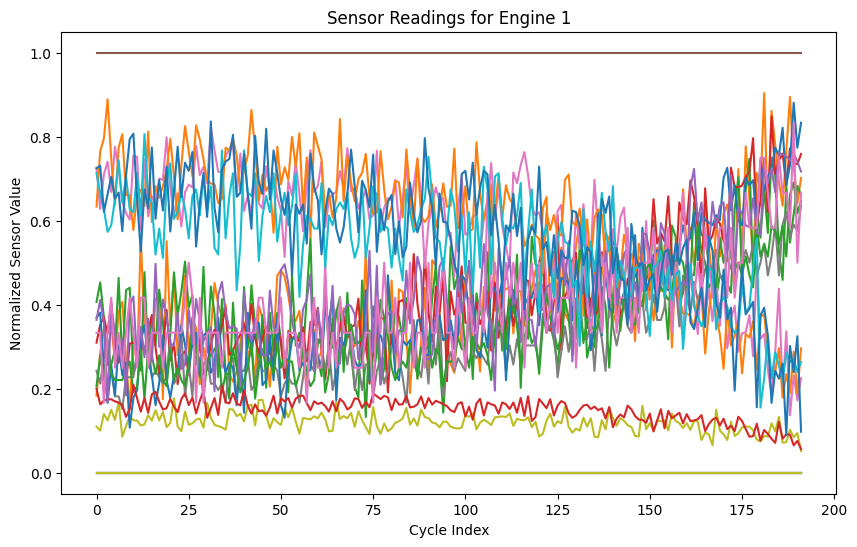

In [10]:
# ----------------------------------
# Visualize multiple sensor readings for a single engine
# ----------------------------------
sensor_cols = [f"s{i}" for i in range(1, 22)]
engine_id = 1
engine_data = df_train[df_train["id"] == engine_id]

plt.figure(figsize=(10, 6))
plt.plot(engine_data[sensor_cols])
plt.xlabel("Cycle Index")
plt.ylabel("Normalized Sensor Value")
plt.title(f"Sensor Readings for Engine {engine_id}")
plt.show()


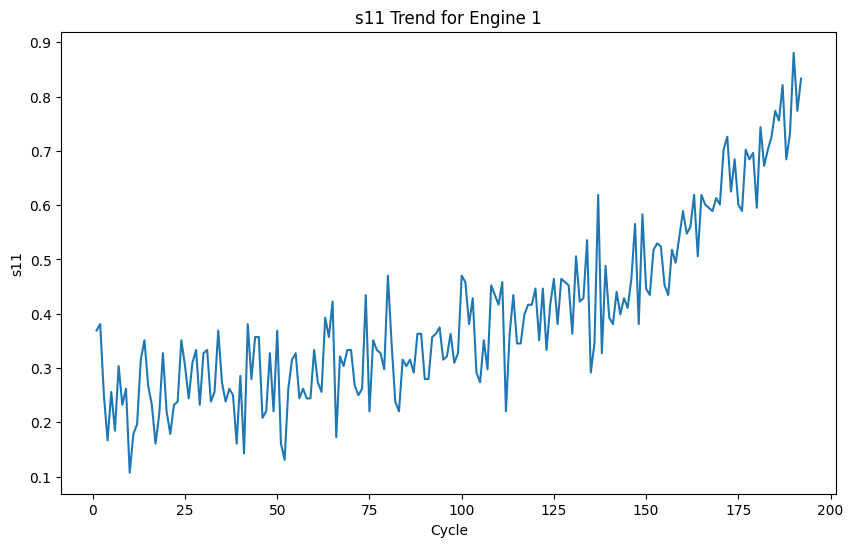

In [11]:
# ----------------------------------
# Visualize degradation trend for a representative sensor
# ----------------------------------
sensor_col = "s11"  # representative sensor

plt.figure(figsize=(10, 6))
plt.plot(engine_data["cycle"], engine_data[sensor_col])
plt.xlabel("Cycle")
plt.ylabel(sensor_col)
plt.title(f"{sensor_col} Trend for Engine {engine_id}")
plt.show()


## Sequence Generation for RNN Training

Recurrent Neural Networks require fixed-length sequences as input.  
This section converts variable-length engine run-to-failure trajectories into overlapping
fixed-length sequences using a sliding window approach.

Each sequence represents sensor and operational settings over `seq_length` cycles,
and the corresponding label indicates whether a failure occurs within the defined prediction window.


In [12]:
# Length of input sequences (number of time steps)
seq_length = 50


In [13]:
# Sensor features
sensor_features = [f"s{i}" for i in range(1, 22)]

# Operational settings and normalized cycle
meta_features = ["setting1", "setting2", "setting3", "cycle_norm"]

# Final input feature list
ip_features = sensor_features + meta_features


In [14]:
def seq_generator(feature_df, seq_length, feature_cols):
    """
    Generate overlapping sequences of length `seq_length` from a single engine dataframe.

    Parameters:
        feature_df (DataFrame): Engine-specific dataframe
        seq_length (int): Length of each sequence
        feature_cols (list): Input feature columns

    Yields:
        np.ndarray: Sequence of shape (seq_length, num_features)
    """
    feature_array = feature_df[feature_cols].values
    num_cycles = feature_array.shape[0]

    for start_idx in range(0, num_cycles - seq_length):
        end_idx = start_idx + seq_length
        yield feature_array[start_idx:end_idx, :]


In [15]:
# Number of unique engines
total_engines = df_train["id"].max()

# Generate sequences for all engines
seq_generated = (
    list(seq_generator(df_train[df_train["id"] == engine_id], seq_length, ip_features))
    for engine_id in range(1, total_engines + 1)
)

# Concatenate all sequences
X_train = np.concatenate(list(seq_generated)).astype(np.float32)

X_train.shape


(15631, 50, 25)

In [16]:
def label_generator(label_df, seq_length, label_col):
    """
    Generate labels aligned with sequence outputs.

    The label at time t corresponds to the last time step of the input sequence.
    """
    label_array = label_df[label_col].values
    return label_array[seq_length:]


In [18]:
label_generated = [
    label_generator(df_train[df_train["id"] == engine_id],
                    seq_length,
                    "failure_within_w1")
    for engine_id in range(1, total_engines + 1)
]

y_train = np.concatenate(label_generated).astype(np.float32).reshape(-1, 1)

y_train.shape


(15631, 1)

## Building model

### LSTM Model Architecture

A stacked LSTM architecture is used to capture temporal degradation patterns in aircraft engine sensor data.
The model predicts whether an engine will fail within a predefined prediction window.


In [19]:
# Feature and output dimensions
feature_dim = X_train.shape[2]
output_dim = y_train.shape[1]

print("Feature dimension:", feature_dim)
print("Output dimension:", output_dim)


Feature dimension: 25
Output dimension: 1


In [20]:
# Paths for saving trained model and logs
model_path = "/content/drive/MyDrive/models/binary_model.keras"
log_path = "/content/drive/MyDrive/logs/PredMaintenanceLog.csv"


In [21]:
from tensorflow.keras.models import Sequential

model = Sequential([
    LSTM(
        units=100,
        input_shape=(seq_length, feature_dim),
        return_sequences=True
    ),
    Dropout(0.2),

    LSTM(
        units=50,
        return_sequences=False
    ),
    Dropout(0.2),

    Dense(output_dim, activation="sigmoid")
])


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [22]:
model.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50, 100)        │        50,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 80,651 (315.04 KB)

 Trainable params: 80,651 (315.04 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
import time

epochs = 200
batch_size = 200

start_time = time.time()

history = model.fit(
    X_train,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.02,
    verbose=2,
    callbacks=[
        EarlyStopping(
            monitor="val_loss",
            patience=10,
            mode="min",
            restore_best_weights=True
        ),
        ModelCheckpoint(
            filepath=model_path,
            monitor="val_loss",
            save_best_only=True,
            mode="min"
        ),
        CSVLogger(log_path, append=True)
    ]
)

end_time = time.time()
print(f"Total training time: {end_time - start_time:.2f} seconds")


Epoch 1/200
77/77 - 31s - 408ms/step - accuracy: 0.9098 - loss: 0.2201 - val_accuracy: 0.9808 - val_loss: 0.0693
Epoch 2/200
77/77 - 36s - 472ms/step - accuracy: 0.9632 - loss: 0.0923 - val_accuracy: 0.9776 - val_loss: 0.0542
Epoch 3/200
77/77 - 18s - 231ms/step - accuracy: 0.9682 - loss: 0.0756 - val_accuracy: 0.9968 - val_loss: 0.0409
Epoch 4/200
77/77 - 22s - 288ms/step - accuracy: 0.9706 - loss: 0.0680 - val_accuracy: 0.9840 - val_loss: 0.0369
Epoch 5/200
77/77 - 18s - 229ms/step - accuracy: 0.9694 - loss: 0.0719 - val_accuracy: 0.9872 - val_loss: 0.0385
Epoch 6/200
77/77 - 18s - 229ms/step - accuracy: 0.9743 - loss: 0.0622 - val_accuracy: 0.9872 - val_loss: 0.0358
Epoch 7/200
77/77 - 20s - 254ms/step - accuracy: 0.9747 - loss: 0.0599 - val_accuracy: 0.9776 - val_loss: 0.0446
Epoch 8/200
77/77 - 17s - 227ms/step - accuracy: 0.9770 - loss: 0.0563 - val_accuracy: 0.9712 - val_loss: 0.0537
Epoch 9/200
77/77 - 18s - 228ms/step - accuracy: 0.9769 - loss: 0.0538 - val_accuracy: 0.9968 - 

In [25]:
pd.DataFrame(history.history)

,accuracy,loss,val_accuracy,val_loss
0,0.909779,0.220127,0.980831,0.069260
1,0.963181,0.092272,0.977636,0.054193
2,0.968207,0.075608,0.996805,0.040943
3,0.970558,0.068000,0.984026,0.036872
4,0.969382,0.071923,0.987220,0.038457
5,0.974344,0.062167,0.987220,0.035816
6,0.974736,0.059914,0.977636,0.044634
7,0.977021,0.056306,0.971246,0.053730
8,0.976890,0.053796,0.996805,0.024678
9,0.973365,0.061703,0.993610,0.037825


### Training and Validation Performance

The following plots show the evolution of accuracy and loss during training.
They help diagnose convergence behavior and potential overfitting.


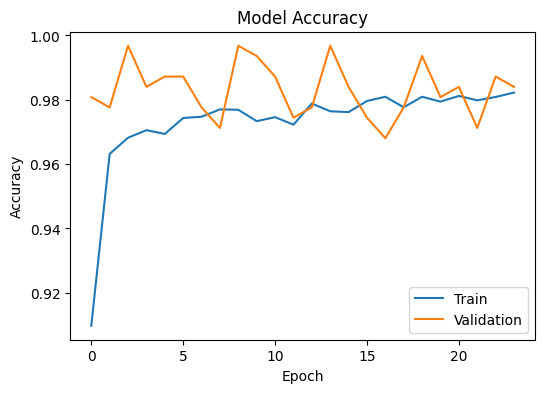

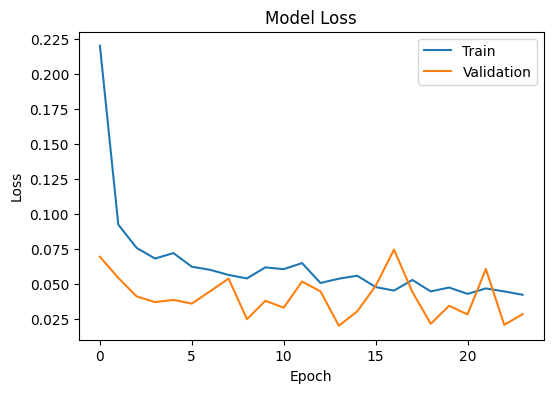

In [26]:
# Accuracy curve
plt.figure(figsize=(6, 4))
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["Train", "Validation"])
plt.show()

# Loss curve
plt.figure(figsize=(6, 4))
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Validation"])
plt.show()


In [27]:
# Evaluate model on training set
train_scores = model.evaluate(
    X_train,
    y_train,
    batch_size=50,
    verbose=1
)

print(f"Training Accuracy: {train_scores[1]:.4f}")


313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - accuracy: 0.9808 - loss: 0.0455
Training Accuracy: 0.9803


In [29]:
# Predict probabilities
y_pred_prob = model.predict(
    X_train,
    batch_size=200,
    verbose=1
)

# Convert probabilities to binary predictions
y_pred = (y_pred_prob > 0.5).astype(int)
y_true = y_train


79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 86ms/step


In [30]:
print("Confusion Matrix")
print("Rows: Predicted labels")
print("Columns: True labels")

cm = confusion_matrix(y_true, y_pred)
cm


Confusion Matrix
Rows: Predicted labels
Columns: True labels


array([[12480,    51],
       [  257,  2843]])

In [31]:
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")


Precision: 0.9824
Recall: 0.9171


## Model evaluation on test set


### Test Sequence Generation

For evaluation, only the most recent `seq_length` cycles of each engine are used.
Each engine contributes a single sequence, simulating real-time failure prediction.


In [32]:
# Generate test sequences using the last seq_length cycles of each engine
x_test_seq = [
    df_test[df_test["id"] == engine_id][ip_features].values[-seq_length:]
    for engine_id in df_test["id"].unique()
    if len(df_test[df_test["id"] == engine_id]) >= seq_length
]

# Convert to NumPy array
X_test = np.asarray(x_test_seq).astype(np.float32)

X_test.shape


(93, 50, 25)

In [33]:
# Mask engines with insufficient cycles
y_mask = [
    len(df_test[df_test["id"] == engine_id]) >= seq_length
    for engine_id in df_test["id"].unique()
]

sum(y_mask)  # Should match number of test sequences


93

In [34]:
# Extract final failure label for each engine
y_test = (
    df_test.groupby("id")["failure_within_w1"]
    .last()
    .values[y_mask]
)

# Reshape to (n_samples, 1)
y_test = y_test.reshape(-1, 1).astype(np.float32)

y_test.shape


(93, 1)

### Evaluation on Test Data

The trained model is evaluated on unseen test data using the last available sequence from each engine.
Performance metrics are computed to assess classification effectiveness.


In [35]:
# Load best saved model
model = load_model(model_path)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50, 100)        │        50,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 241,955 (945.14 KB)

 Trainable params: 80,651 (315.04 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 161,304 (630.10 KB)

In [36]:
test_scores = model.evaluate(
    X_test,
    y_test,
    batch_size=200,
    verbose=1
)

print(f"Test Accuracy: {test_scores[1]:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9677 - loss: 0.0778
Test Accuracy: 0.9677


In [37]:
# Predict failure probabilities
y_pred_prob = model.predict(
    X_test,
    batch_size=200,
    verbose=1
)

# Convert probabilities to binary predictions
y_pred = (y_pred_prob > 0.5).astype(int)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step


In [38]:
cm = confusion_matrix(y_test, y_pred)
cm


array([[67,  1],
       [ 2, 23]])

In [39]:
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1_score = 2 * precision * recall / (precision + recall)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")


Precision: 0.9583
Recall: 0.9200
F1 Score: 0.9388


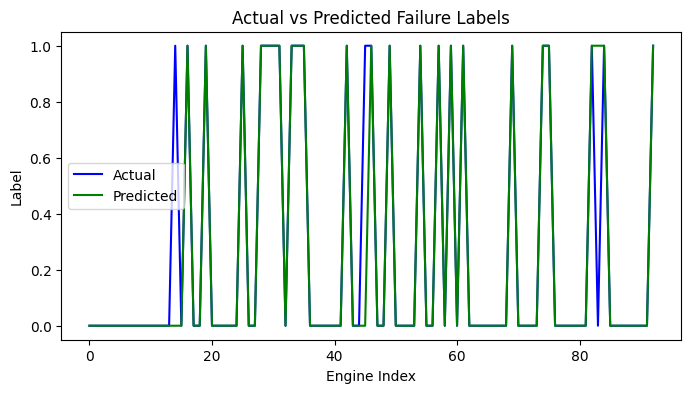

In [40]:
plt.figure(figsize=(8, 4))
plt.plot(y_test, label="Actual", color="blue")
plt.plot(y_pred, label="Predicted", color="green")
plt.title("Actual vs Predicted Failure Labels")
plt.xlabel("Engine Index")
plt.ylabel("Label")
plt.legend()
plt.show()


## Conclusion

In this project, a predictive maintenance framework was developed to identify potential aircraft engine failures using multivariate time-series sensor data. The dataset was preprocessed to compute Remaining Useful Life (RUL), generate binary failure labels, and normalize sensor readings for effective temporal modeling.

A stacked LSTM-based recurrent neural network was implemented to capture degradation patterns across multiple operational cycles. Fixed-length sequences were generated using a sliding window approach for training, while test-time evaluation was performed using only the most recent sensor history of each engine, closely reflecting real-world deployment scenarios.

The trained model demonstrated its ability to learn meaningful temporal representations, achieving reliable performance on unseen test data. Precision, recall, and F1-score were used alongside accuracy to evaluate classification effectiveness, ensuring that failure prediction performance was assessed beyond simple accuracy metrics.

Overall, this project highlights the applicability of deep learning–based sequence models for predictive maintenance tasks in aerospace systems. The approach can be extended further by incorporating advanced architectures, remaining useful life regression, and real-time inference pipelines for operational deployment.


## Future Work

- Extend the model to predict continuous Remaining Useful Life (RUL) to support maintenance scheduling decisions.
- Experiment with GRU and attention-based architectures to improve efficiency and interpretability.
- Perform systematic hyperparameter tuning and cross-validation for more robust performance estimation.
- Develop a real-time inference pipeline for continuous engine health monitoring.
- Analyze sensor importance to improve model interpretability and domain insights.
